In [16]:
import cv2
import time
import torch
import numpy as np
import robotic as ry
import matplotlib.pyplot as plt

from models.mlp import MLP
from models.autoencoders import AE
from Robotic_Manipulation.shelf import generate_target_box

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device)}" if device.type == "cuda" else "Using cpu")
IMAGE_RESIZE = 256
LATENT_DIM = 6
AE_PATH = "./logs/models/autoencoder_2024-10-21_15:24/pth/epoch_2000.pth"
L2W_PATH = "./logs/models/mlp_2024-10-25_15:27/pth/epoch_400.pth"

Device Name: NVIDIA GeForce RTX 3090


In [18]:
# Define the new config
C = ry.Config()
C.addFile(ry.raiPath("scenarios/pandaSingle.g"))

generate_target_box(C, [-.3, .3, .75])

box_frame = C.addFrame("box") \
    .setPosition([.3, .3, .8]) \
    .setShape(ry.ST.ssBox, size=[.05, .05, .12, .001]) \
    .setColor([1., 1., 0.]) \
    .setContact(1) \
    .setMass(1.)

# For convenience, a few definitions:
gripper = "l_gripper"
box = "box"
table = "table"

C.view()

bot = ry.BotOp(C, False)
bot.home(C)
bot.gripperMove(ry._left)
while not bot.gripperDone(ry._left):
    bot.sync(C)
qHome = C.getJointState()

-- bot.cpp:~BotOp:135(0) shutting down BotOp...
-- simulation.cpp:~BotThreadedSim:57(0) shutting down SimThread
-- simulation.cpp:~Simulation:148(0) shutting down Simulation


In [19]:
image_encoder = AE(latent_dim=LATENT_DIM).to(device=device)
image_encoder.load_state_dict(torch.load(AE_PATH, map_location=device))
image_encoder.eval()

mlp_model = MLP(LATENT_DIM, 9, hidden_layers=[256, 128]).to(device)
mlp_model.load_state_dict(torch.load(L2W_PATH, map_location=device))
mlp_model.eval()

/tmp/ipykernel_6689/3462051912.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_encoder.load_state_dict(torch.load(AE_PATH, map_location=device))
/tmp/ipykernel_668

MLP(
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=9, bias=True)
  )
)

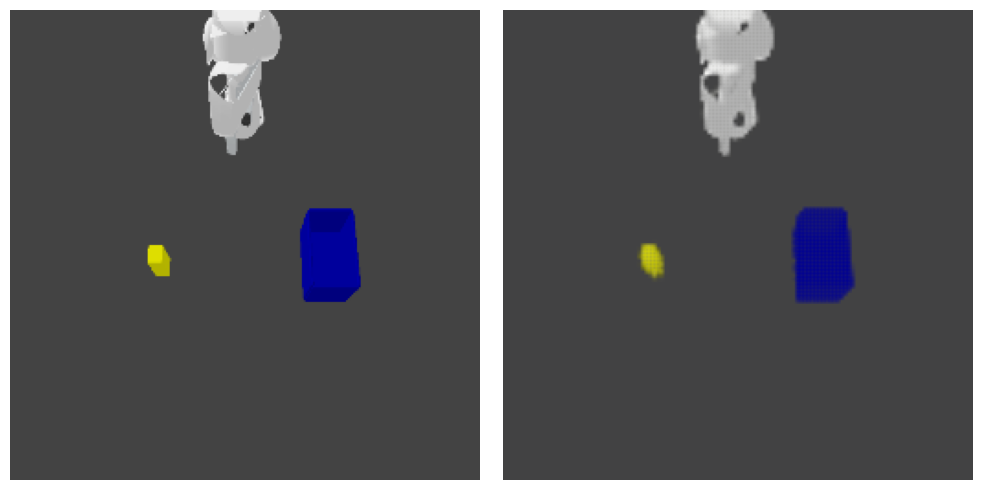

(3, 3)
-- WARNING:kin.cpp:getFrame:412(-1) cannot find frame named 'way0'
-- WARNING:kin.cpp:getFrame:412(-1) cannot find frame named 'way1'
-- WARNING:kin.cpp:getFrame:412(-1) cannot find frame named 'way2'
-- bot.cpp:~BotOp:135(0) shutting down BotOp...
-- simulation.cpp:~BotThreadedSim:57(0) shutting down SimThread
-- simulation.cpp:~Simulation:148(0) shutting down Simulation


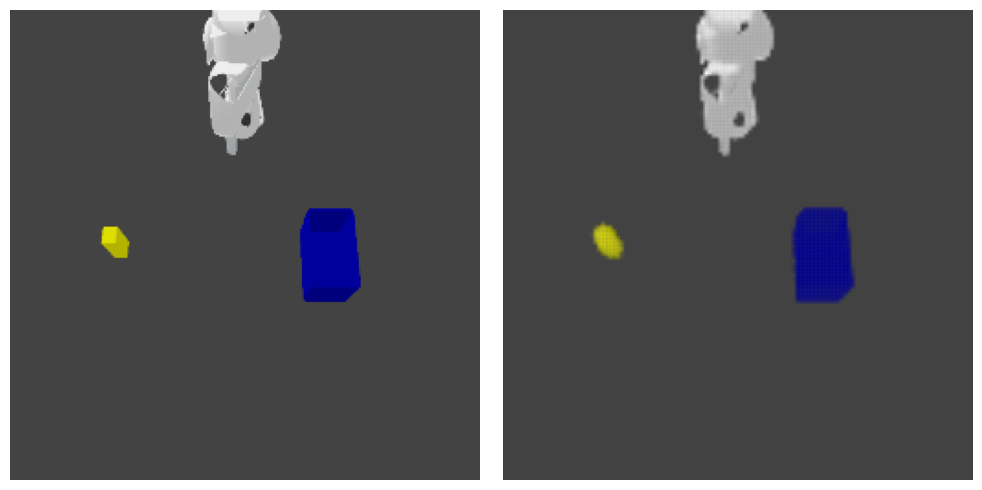

(3, 3)
[0.45726308 0.26051036 0.7496316 ]
[-0.29229397  0.29477647  1.0224841 ]
[-0.29335913  0.29393202  1.0229311 ]
-- bot.cpp:~BotOp:135(0) shutting down BotOp...
-- simulation.cpp:~BotThreadedSim:57(0) shutting down SimThread
-- simulation.cpp:~Simulation:148(0) shutting down Simulation


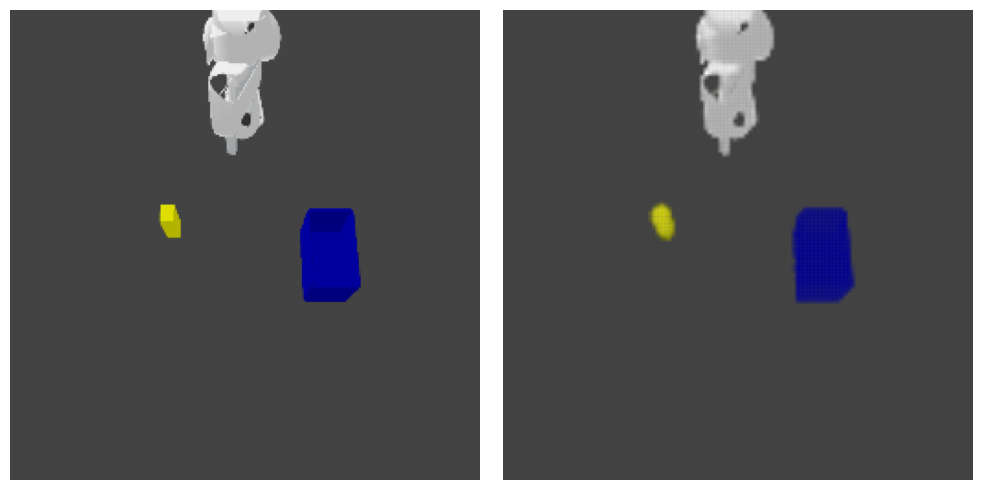

(3, 3)
[0.2714594  0.19155568 0.74951464]
[-0.28715527  0.28084388  1.0176243 ]
[-0.28804627  0.28028238  1.0181932 ]
-- bot.cpp:~BotOp:135(0) shutting down BotOp...
-- simulation.cpp:~BotThreadedSim:57(0) shutting down SimThread
-- simulation.cpp:~Simulation:148(0) shutting down Simulation


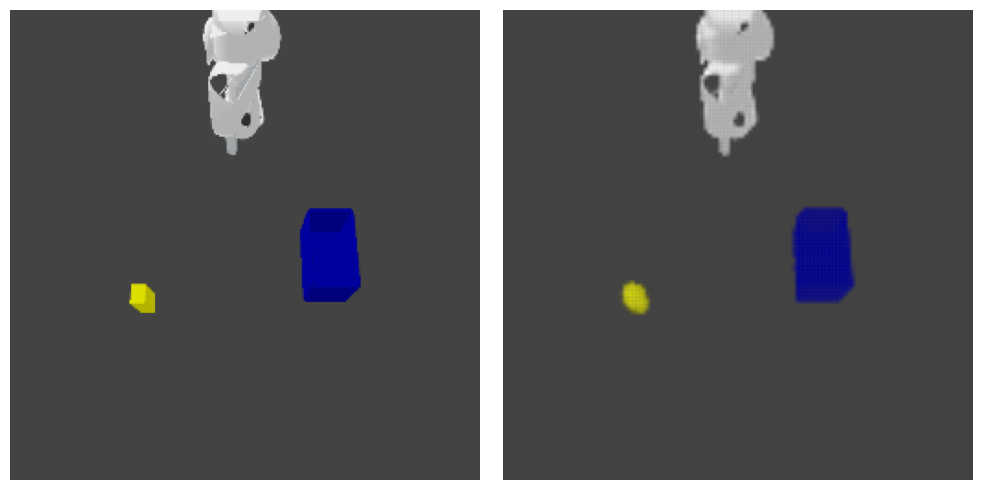

(3, 3)
[0.34565136 0.3992053  0.7500196 ]
[-0.29541317  0.30190048  1.0225177 ]
[-0.29618555  0.3011547   1.0228899 ]
-- bot.cpp:~BotOp:135(0) shutting down BotOp...
-- simulation.cpp:~BotThreadedSim:57(0) shutting down SimThread
-- simulation.cpp:~Simulation:148(0) shutting down Simulation


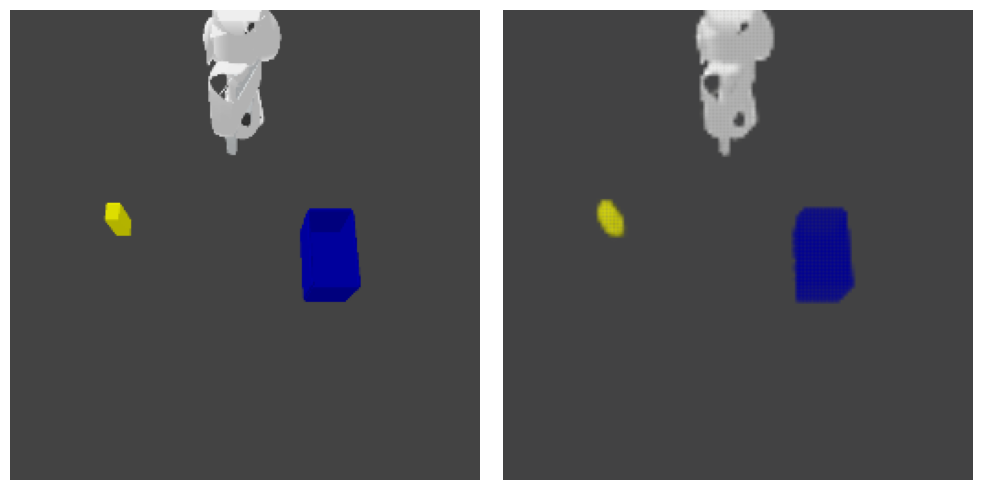

(3, 3)
[0.46095532 0.191328   0.7494416 ]
[-0.28970236  0.28900728  1.0211937 ]
[-0.2909221  0.2881655  1.0218316]
-- bot.cpp:~BotOp:135(0) shutting down BotOp...
-- simulation.cpp:~BotThreadedSim:57(0) shutting down SimThread
-- simulation.cpp:~Simulation:148(0) shutting down Simulation


In [20]:
for i in range(5):
    # Get input data
    image, depth = bot.getImageAndDepth("cameraTop")
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_RESIZE, IMAGE_RESIZE))
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    image = image/255.0
    image = np.transpose(image, (2, 0, 1))  # HWC to CHW

    # Perform inference
    latent_im = image_encoder.encode(torch.Tensor([image]).to(device))
    decoded_image = image_encoder.forward_clean(torch.Tensor([image]).to(device))[0]

    axes[1].imshow(decoded_image)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

    waypoints = mlp_model(latent_im).detach().cpu().numpy()[0].reshape(3, 3)
    print(waypoints.shape)
    for i, way in enumerate(waypoints):
        frame = C.getFrame(f"way{i}")
        if frame:
            frame.setPosition(way)
            print(way)
        else:
            frame = C.addFrame(f"way{i}").setShape(ry.ST.marker, [.2]).setPosition(way)
        if i == 0:
            frame.setColor([1., 0., 0., 1.])
    C.view()
    time.sleep(2.)
    for i, _ in enumerate(waypoints):
        frame = C.getFrame(f"way{i}")
        if frame:
            frame.setPosition([0., 0., 0.])
    del bot
    x_dev = np.random.random() * .4 -.2
    y_dev = np.random.random() * .3 -.15
    box_frame.setQuaternion([1., 0., 0., 0.])
    box_frame.setPosition([.3 + x_dev, .3 + y_dev, .8])
    C.setJointState(qHome)
    C.view()
    bot = ry.BotOp(C, useRealRobot=False)
    bot.home(C)
    bot.gripperMove(ry._left)
    bot.sync(C, 2.)

In [21]:
# Go through waypoints
komo = ry.KOMO(C, waypoints.shape[0], 20, 2, False)
komo.addControlObjective([], 1, .1)
komo.addControlObjective([], 2, .01)

for i, way in enumerate(waypoints):
    komo.addObjective([i+1.], ry.FS.position, ["l_gripper"], ry.OT.eq, [1e1], way)

komo.addObjective([1., waypoints.shape[0]], ry.FS.vectorZ, ["l_gripper"], ry.OT.eq, [1e1], [0, 0, 1])

sol = ry.NLP_Solver()
sol.setProblem(komo.nlp())
sol.setOptions(damping=1e-3, verbose=0, stopTolerance=1e-3, maxLambda=100., stopEvals=200)
ret = sol.solve()

if ret.feasible:
    print("Feasible")
    bot.move(komo.getPath(), [10.])
    bot.wait(C)
    bot.home(C)
else:
    print("Path infeasible!")

Feasible
